In [1]:
import os
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, argrelextrema, find_peaks, argrelmax, argrelmin
import scipy.ndimage as ndimage
import skimage.morphology as morphology

In [2]:
path_h = glob("/home/usman/MServer/AIRD_Data/Projects/Internal/X-ray Left hand/2hands/*.jpg",recursive = True)
len(path_h)

39

In [3]:
path_l = glob("/home/usman/MServer/AIRD_Data/Projects/Internal/X-ray Left hand/left_hand/*/**.jpg",recursive = True)
len(path_l)

44

In [4]:
def needs_cropping(gray):
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)
    (T, msk) = cv2.threshold(blurred, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    msk = cv2.bitwise_not(msk)
    #plt.figure()
    #plt.imshow(msk)
    msk = msk>0
    msk = morphology.remove_small_objects(msk, min_size=min(msk.shape[0]*(2/3),msk.shape[1]*(2/3)))
    msk = ndimage.morphology.binary_closing(msk)#.astype(int)
    #plt.figure()
    #plt.imshow(msk)
    contours, _ = cv2.findContours(msk.astype(np.uint8),cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    area = 0
    for cnt in contours:
        a = cv2.contourArea(cnt)
        if a > area:
            area = a
            cont = cnt
    if area > msk.shape[0]*msk.shape[1]/3:
        x,y,w,h = cv2.boundingRect(cont)
        print('needs cropping')
        return [x,y,w,h]
    else:
        return []

In [23]:
def crop_left_hand(image):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    hands = image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    coord = needs_cropping(gray)
    if not coord==[]:
        x,y,w,h = coord
        image = image[y+5:y+h-5,x+5:x+w-5,:]
        gray = gray[y+5:y+h-5,x+5:x+w-5]
        hands = hands[y+5:y+h-5,x+5:x+w-5,:]
    mean = np.mean(gray)
    mean /= 255
    low_th = ((100-20)* mean) + 20
    high_th = ((180-50)*mean) + 50
    crop = False
    blurred = gray
    bray = cv2.Canny(blurred, low_th, high_th)
    plt.figure(figsize=(10,10))
    plt.imshow(bray)
    h = np.sum(bray,axis = 0)
    h = h/np.amax(h)
    plt.figure(figsize=(10,10))
    plt.plot(h)
    hstart = h[:int(len(h)/10)]
    hend = h[-int(len(h)/10):]
    #plt.plot(hstart)
    pst = find_peaks(hstart,prominence=0.1)
    pen = find_peaks(hend,prominence=0.1)
    if len(pst[0])>0:
        h[:int(len(h)/10)] = 0
    if len(pen[0])>0:
        h[-int(len(h)/10):] = 0
    h = h/np.amax(h)
    le = int(3*len(h)/4)
    if le%2==0:
        le = le -1
    hhh = savgol_filter(h.flatten(),le,3)
    hhh = hhh/np.amax(hhh)
    plt.figure(figsize=(10,10))
    plt.plot(hhh)
    peak = argrelmax(hhh, order = 2)
    peak = peak[0]
    a = 0
    actual_peaks = []
    if len(peak)>1:
        for i in range(len(peak)):
            if a==0:
                a = peak[i]
                actual_peaks.append(a)
            else:
                if (a < (peak[i] - hhh.shape[0]/6)) or (a > (peak[i] + hhh.shape[0]/6)):
                    a = peak[i]
                    actual_peaks.append(a)
    if len(actual_peaks)>1:
        crop = True
    if crop==True:
        start = int(h.shape[0]*0.25)
        end = int(h.shape[0]*0.75)
        
        h = h[start : end]
        points = np.argwhere(h==np.amin(h))
        gap_s = np.squeeze(start + min(points))
        gap_e = np.squeeze(start + max(points))
        crop_mid = round((gap_s + gap_e)/2)
        left_hand = hands[:,:crop_mid,:]
        blurred = cv2.GaussianBlur(gray, (7, 7), 0)
        (T, msk) = cv2.threshold(blurred, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
        msk = cv2.bitwise_not(msk)
        plt.figure(figsize=(10,10))
        plt.imshow(msk)
        m = np.sum(msk,axis = 0)
        m = m/np.amax(m)
        plt.figure(figsize=(10,10))
        plt.plot(m)
        le = int(3*len(m)/4)
        if le%2==0:
            le = le -1
        mmm = savgol_filter(m.flatten(),le,3)
        mmm = mmm/np.amax(mmm)
        plt.figure(figsize=(10,10))
        plt.plot(mmm)
        ml = mmm[:int(mmm.shape[0]/2)]
        mr = mmm[int(mmm.shape[0]/2):] 
        mlm = max(ml)
        mrm = max(mr)
        lm = np.where(mmm==mlm)[0][0]
        lr = np.where(mmm==mrm)[0][0]
        
        dum = mmm[lm:lr]
        peak = argrelmin(mmm, order = 2)
        pay = []
        #
        for p in peak[0]:
            if (p>lm) and (p<lr):
                pay.append(p)
        a=0
        actual_peakss = []
        peak = peak[0]
        if len(peak)>1:
            for i in range(len(peak)):
                if a==0:
                    a = peak[i]
                    actual_peakss.append(a)
                else:
                    if (a < (peak[i] - hhh.shape[0]/9)) or (a > (peak[i] + hhh.shape[0]/9)):
                        a = peak[i]
                        actual_peakss.append(a)
        if not np.amin(h)==0:
            for p in mmm[actual_peakss]:
                if p < np.amin(hhh[actual_peaks[0]:actual_peaks[-1]]):
                    if len(actual_peakss) > 1:
                        crop_mid = round((actual_peakss[0]+actual_peakss[1])/2)
                    else:
                        crop_mid = actual_peakss[0]
                    left_hand = hands[:,:crop_mid,:]
                    break
        
        return left_hand ###crop, left_hand
    else:
        return hands
    

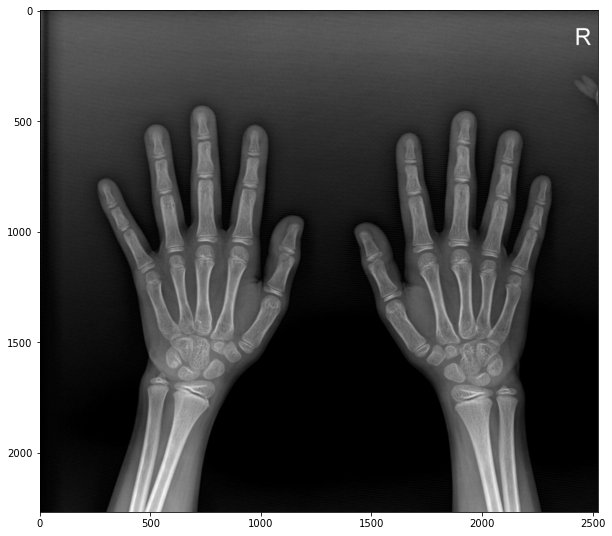

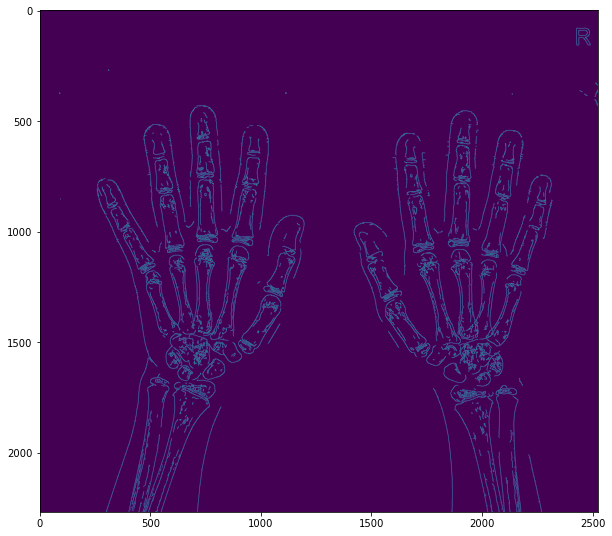

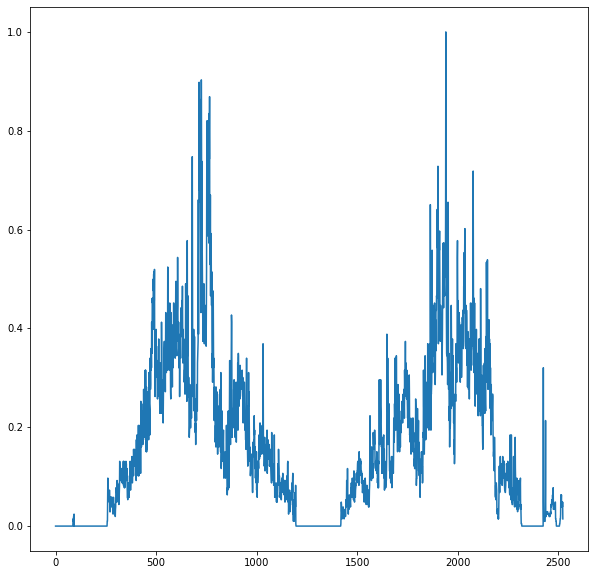

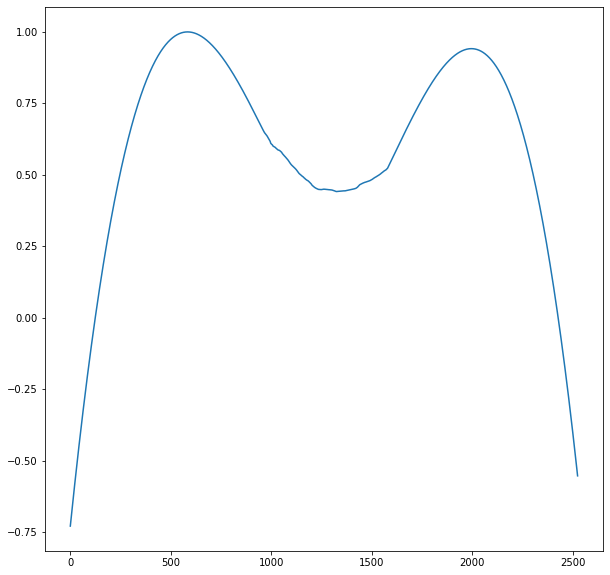

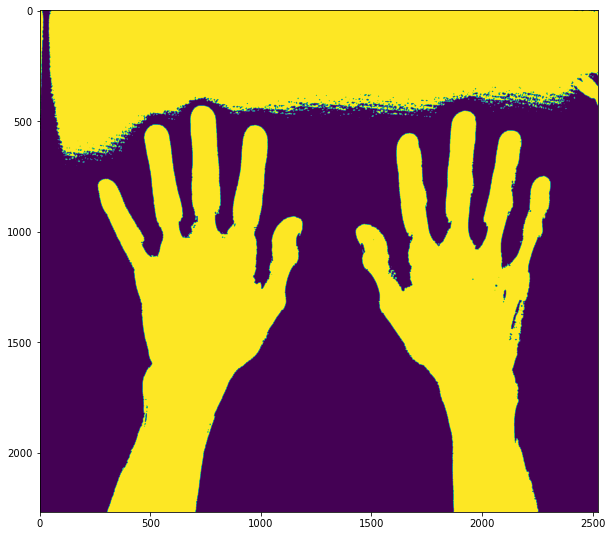

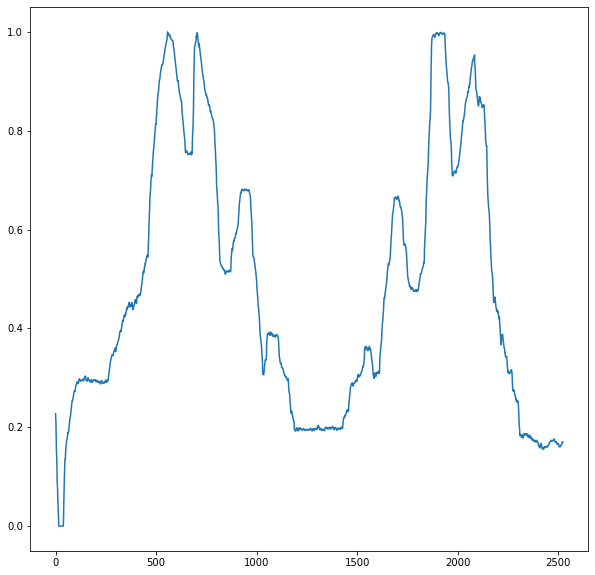

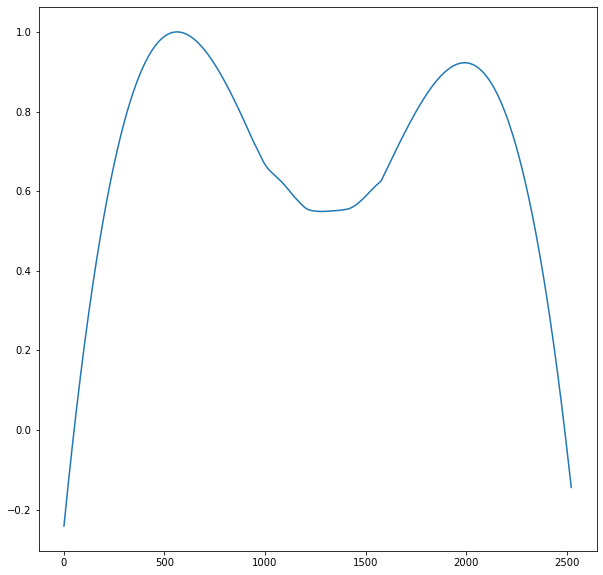

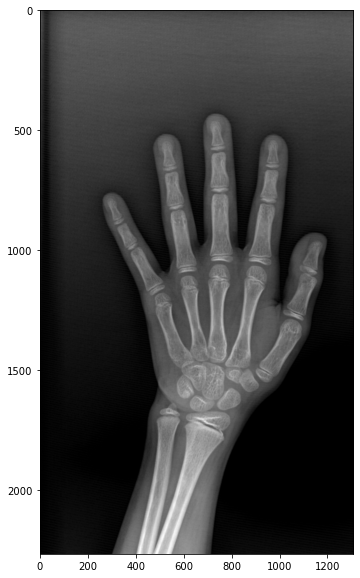

In [41]:
left = crop_left_hand(cv2.imread(path_h[16]))
plt.figure(figsize=(10,10))
plt.imshow(left)

In [373]:
from tqdm import tqdm

In [374]:
for i in tqdm(range(len(path_l))):
    flag, left = crop_left_hand(cv2.imread(path_l[i]))
    if flag==True:
        print(i)

100%|███████████████████████████████████████████| 44/44 [00:22<00:00,  1.93it/s]


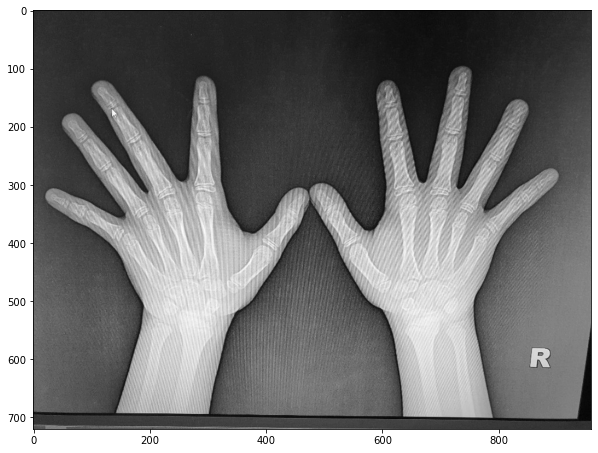

In [198]:
image = hands =  cv2.imread(path_h[12])   #21 22 37   #32 33
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.figure(figsize = (10,10))
plt.imshow(gray,'gray')

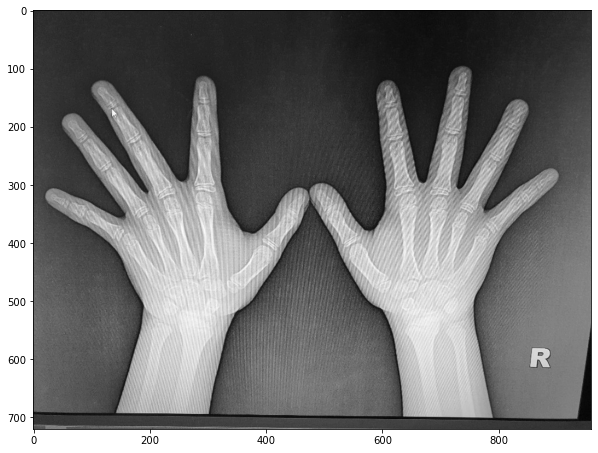

In [199]:
coord = needs_cropping(gray)
if not coord==[]:
    x,y,w,h = coord
    image = image[y+5:y+h-5,x+5:x+w-5,:]
    gray = gray[y:y+h,x:x+w]
plt.figure(figsize = (10,10))
plt.imshow(gray,'gray')

In [200]:
np.mean(gray)

102.10454861111111

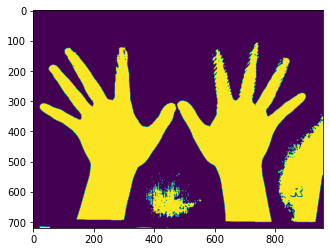

In [207]:
blurred = cv2.GaussianBlur(gray, (7, 7), 0)
(T, msk) = cv2.threshold(blurred, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
msk = cv2.bitwise_not(msk)
plt.imshow(msk)

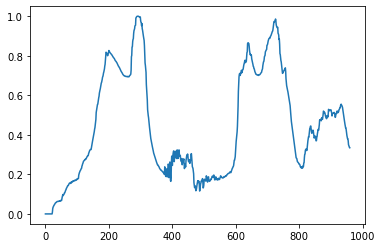

In [208]:
m = np.sum(msk,axis = 0)
m = m/np.amax(m)
plt.plot(m)

719


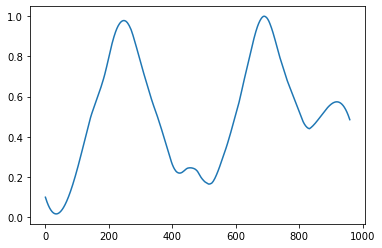

In [209]:
le = int(3*len(m)/4)
if le%2==0:
    le = le -1
print(le)
mmm = savgol_filter(m.flatten(),255,3)
mmm = mmm/np.amax(mmm)
plt.plot(mmm)


In [210]:
ml = mmm[:int(mmm.shape[0]/2)]
mr = mmm[int(mmm.shape[0]/2):] 
mlm = max(ml)
mrm = max(mr)
print(mlm,mrm)

0.9786000996241384 1.0


In [214]:
if (mlm>0.8) and (mrm>0.8):
    lm = np.where(mmm==mlm)[0][0]
    lr = np.where(mmm==mrm)[0][0]
    print(lm,lr)

247 689


In [221]:
peak = argrelmin(mmm, order = 2)
print(peak[0])
pay = []
for p in peak[0]:
    if (p>lm) and (p<lr):
        pay.append(p)
pay

[ 34 423 515 832]


[423, 515]

In [ ]:
if len(pay) > 1:
    crop_mid = round((pay[0]+pay[1])/2)
else:
    crop_mid = pay[0]

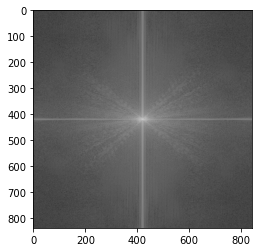

In [141]:
f = np.fft.fft2(gray)
fshift = np.fft.fftshift(f)
# calculate amplitude spectrum
mag_spec = 20*np.log(np.abs(fshift))
plt.imshow(mag_spec,'gray')

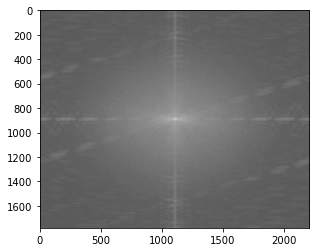

In [146]:
f = np.fft.fft2(gray)
fshift = np.fft.fftshift(f)
# calculate amplitude spectrum
mag_spec = 20*np.log(np.abs(fshift))
plt.imshow(mag_spec,'gray')

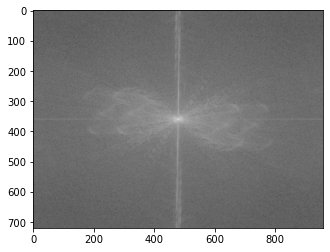

In [173]:
f = np.fft.fft2(gray)
fshift = np.fft.fftshift(f)
# calculate amplitude spectrum
mag_spec = 20*np.log(np.abs(fshift))
plt.imshow(mag_spec,'gray')

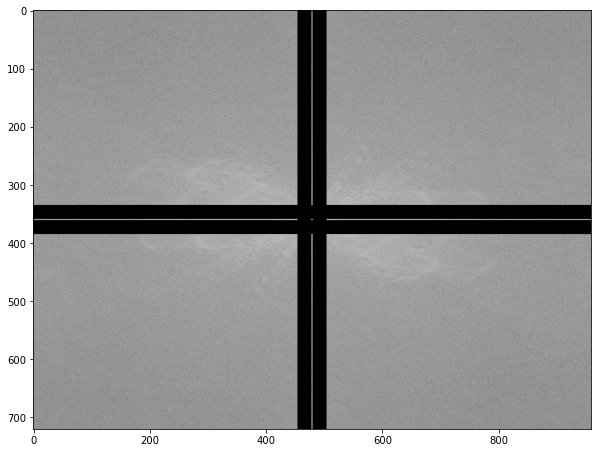

In [195]:
r = round(f.shape[0]/2)        # number of rows/2
c = round(f.shape[1]/2)        # number of columns/2   
p = 25                         
n = 1                   # to suppress all except for the DC component       
fshift2 = np.copy(fshift)
# suppress upper part
fshift2[r-p:r-n ,:] = 0.001
fshift2[r+n:r+p ,:] = 0.001
# suppress lower part
fshift2[:,  c-p:c-n] = 0.001
fshift2[:,  c+n:c+p] = 0.001
# calculate new amplitude spectrum
mag_spec2 = 20*np.log(np.abs(fshift2))
inv_fshift = np.fft.ifftshift(fshift2)
plt.figure(figsize = (10,10))
plt.imshow(mag_spec2,'gray')

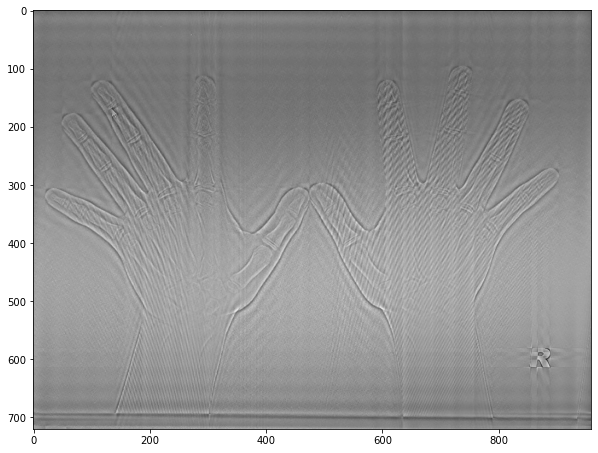

In [196]:

# reconstruct image
img_recon = np.real(np.fft.ifft2(inv_fshift))
plt.figure(figsize = (10,10))
plt.imshow(img_recon,'gray')

102.10454861111108
0.4004099945533768
52.03279956427014 102.05329929193898


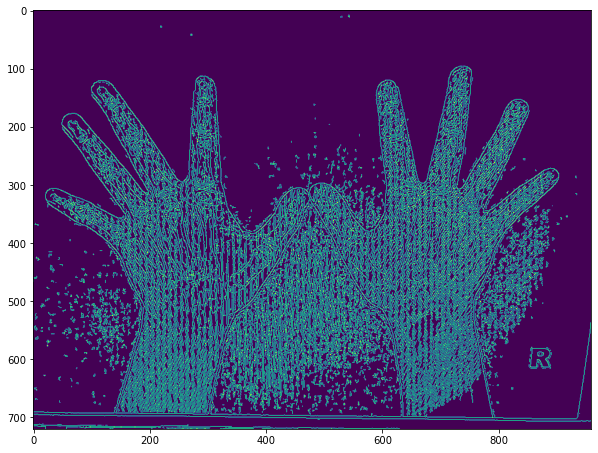

In [197]:
mean = np.mean(img_recon)
print(mean)
mean /= 255
print(mean)
low_th = ((100-20)* mean) + 20
high_th = ((180-50)*mean) + 50
print(low_th, high_th)

bray = cv2.Canny(gray, low_th, high_th)

plt.figure(figsize = (10,10))
plt.imshow(bray)

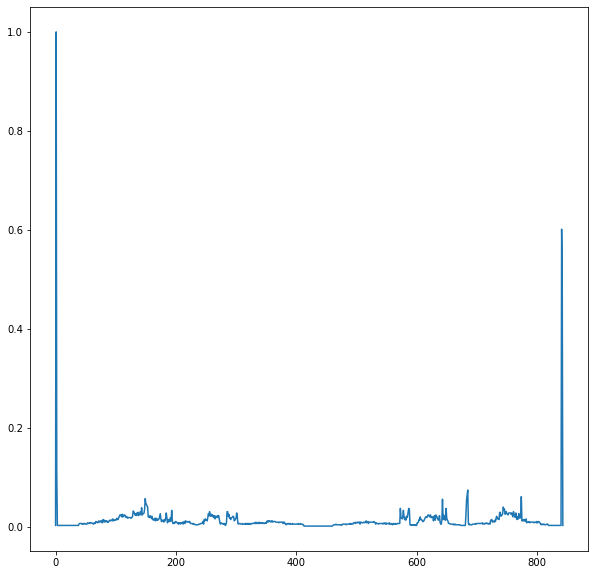

In [68]:
h = np.sum(bray,axis = 0)
h = h/np.amax(h)
plt.figure(figsize = (10,10))
plt.plot(h)

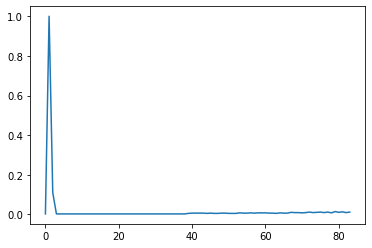

In [69]:
hstart = h[:int(len(h)/10)]
hend = h[-int(len(h)/10):]
plt.plot(hstart)
pst = find_peaks(hstart,prominence=0.1)
pen = find_peaks(hend,prominence=0.1)
if len(pst[0])>0:
    h[:int(len(h)/10)] = 0
if len(pen[0])>0:
    h[-int(len(h)/10):] = 0
h = h/np.amax(h)

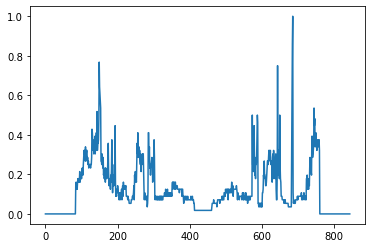

In [70]:

plt.plot(h)

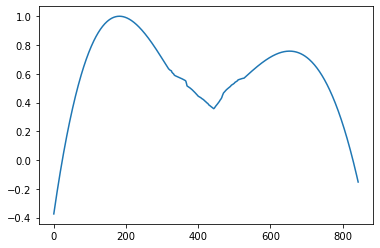

In [71]:
le = int(3*len(h)/4)
if le%2==0:
    le = le -1
hhh = savgol_filter(h.flatten(),le,3)
hhh = hhh/np.amax(hhh)
plt.plot(hhh)

In [72]:
peak = argrelmax(hhh, order = 2)
#peak = find_peaks(hhh,prominence=0) ## height=None, threshold=0.5, distance=None, 
#peak = argrelextrema(hhh[:int(hhh.shape[0])], np.greater)
peak

(array([182, 653]),)

In [22]:
len(hhh)

844

In [23]:
peak[0][1]

653

In [ ]:
if peak

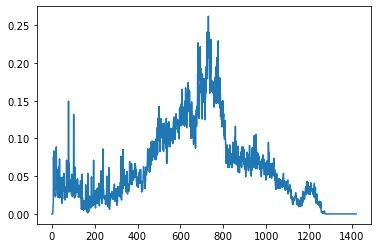

In [67]:
hl = h[:int(h.shape[0]/2)]
hr = h[int(h.shape[0]/2):] 
plt.plot(hl)

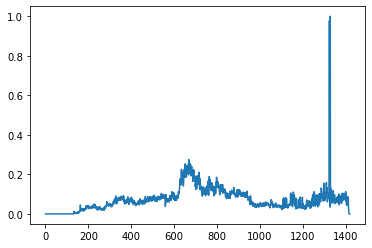

In [68]:
plt.plot(hr)

In [11]:
hlm = max(hl)
hrm = max(hr)
print(hlm,hrm)

0.996031746031746 1.0


In [12]:
if (hlm>0.8) and (hrm>0.8):
    crop = True
print(crop)

True


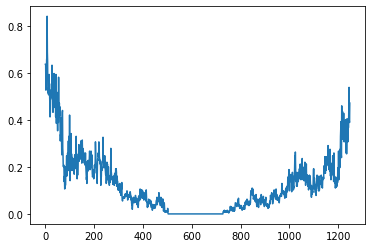

In [271]:
start = int(h.shape[0]*0.25)
end = int(h.shape[0]*0.75)
h = h[start : end]
plt.plot(h)

In [272]:
points = np.argwhere(h==np.amin(h))
#points = np.squeeze(points)
points

array([[503],
       [504],
       [505],
       [506],
       [507],
       [508],
       [509],
       [510],
       [511],
       [512],
       [513],
       [514],
       [515],
       [516],
       [517],
       [518],
       [519],
       [520],
       [521],
       [522],
       [523],
       [524],
       [525],
       [526],
       [527],
       [528],
       [529],
       [530],
       [531],
       [532],
       [533],
       [534],
       [535],
       [536],
       [537],
       [538],
       [539],
       [540],
       [541],
       [542],
       [543],
       [544],
       [545],
       [546],
       [547],
       [548],
       [549],
       [550],
       [551],
       [552],
       [553],
       [554],
       [555],
       [556],
       [557],
       [558],
       [559],
       [560],
       [561],
       [562],
       [563],
       [564],
       [565],
       [566],
       [567],
       [568],
       [569],
       [570],
       [571],
       [572],
       [573],
      

In [273]:
gap_s = np.squeeze(start + min(points))
gap_e = np.squeeze(start + max(points))
print(gap_s,gap_e)

1127 1351


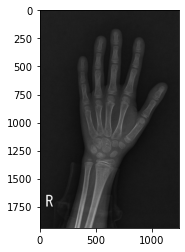

In [274]:
crop_mid = round((gap_s + gap_e)/2)
left_hand = hands[:,:crop_mid,:]
plt.imshow(left_hand)

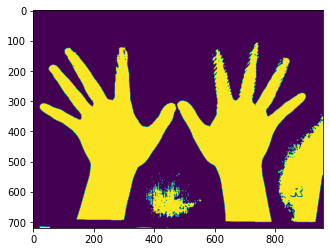

In [57]:
blurred = cv2.GaussianBlur(gray, (7, 7), 0)
(T, msk) = cv2.threshold(blurred, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
msk = cv2.bitwise_not(msk)
plt.imshow(msk)

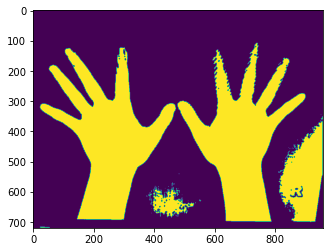

In [58]:
msk = ndimage.morphology.binary_erosion(msk)
plt.imshow(msk)

In [310]:
np.unique(msk)

array([False,  True])

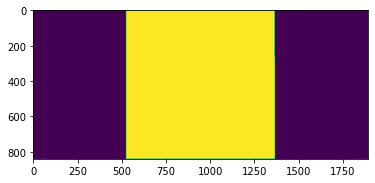

In [309]:
msk = msk>0
msk = morphology.remove_small_objects(msk, min_size=min(msk.shape[0]*(2/3),msk.shape[1]*(2/3)))
msk = ndimage.morphology.binary_closing(msk)#.astype(int)
plt.imshow(msk)
                                      

In [314]:
#imm = cv2.drawContours(imm.astype(np.uint8),contours,-1,255,10)
#plt.imshow(imm)
contours, _ = cv2.findContours(msk.astype(np.uint8),cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
imm = np.zeros_like(msk)
area = 0
for cnt in contours:
    a = cv2.contourArea(cnt)
    if a > area:
        area = a
        cont = cnt
if area > msk.shape[0]*msk.shape[1]/3:
    x,y,w,h = cv2.boundingRect(cont)
    image = image[y:y+h,x:x+w,:]
    bray = bray[y:y+h,x:x+w]
    gray = gray[y:y+h,x:x+w]
    print('needs cropping')

needs cropping


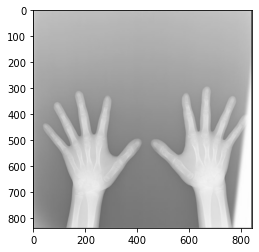

In [315]:
plt.imshow(image)

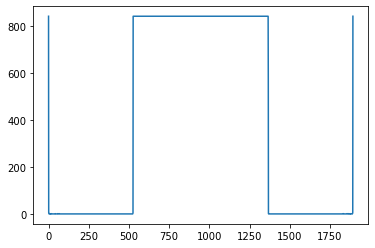

In [286]:
k = np.sum(msk,axis=0)
plt.plot(k)

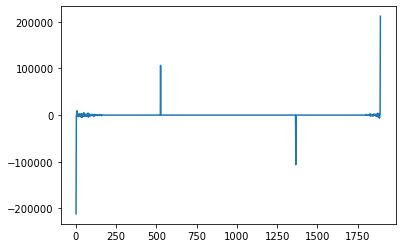

In [269]:
kk = np.gradient(k)
plt.plot(kk)

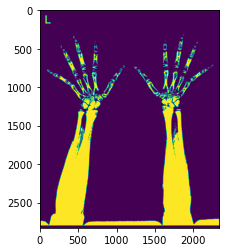

In [726]:
for i in range(msk.shape[0]-1,-1,-1):
    if np.all(msk[i]):
        msk[i] = np.zeros((msk.shape[1]))
plt.imshow(msk)

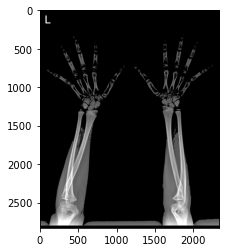

In [727]:
gray = cv2.bitwise_and(gray,gray, mask=msk)
plt.imshow(gray,'gray')

In [728]:
template = np.load('temp_r.npy')
template = cv2.Canny(template, 50, 200)
image = np.dstack([gray,gray,gray])

1.0
0.9578947368421054
0.9157894736842105
0.8736842105263158
0.831578947368421
0.7894736842105263
0.7473684210526317
0.7052631578947368
0.6631578947368422
0.6210526315789473
0.5789473684210527
0.5368421052631579
0.49473684210526314
0.45263157894736844
0.4105263157894737
0.368421052631579
0.3263157894736842
0.28421052631578947
0.24210526315789474
0.2


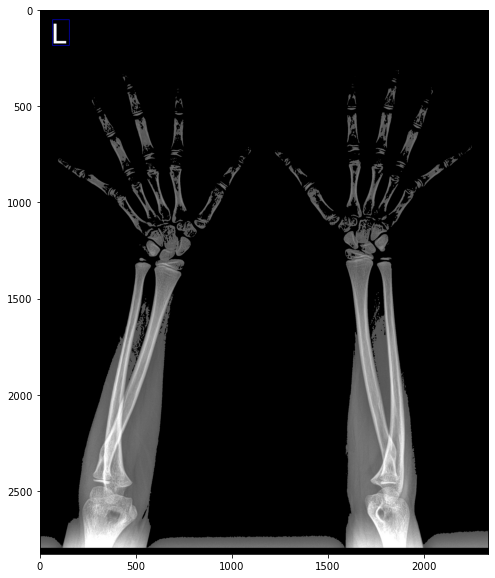

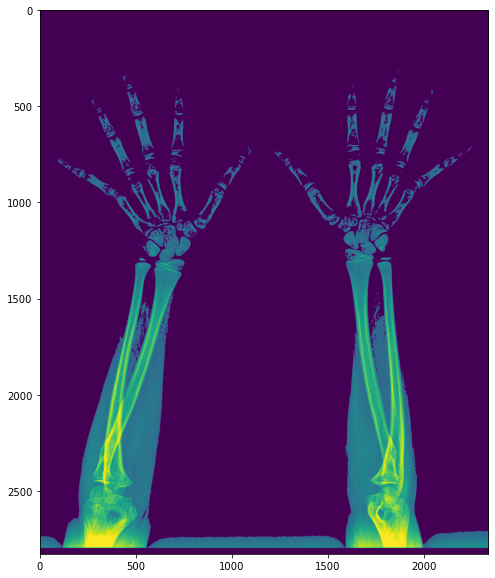

In [729]:
glob_flag = False
found = None
(tH, tW) = template.shape
for scale in np.linspace(0.2, 1.0, 20)[::-1]:
    print(scale)
    resized = imutils.resize(gray, width = int(gray.shape[1] * scale))
    r = gray.shape[1] / float(resized.shape[1])
    # if the resized image is smaller than the template, then break
    # from the loop
    if resized.shape[0] < tH or resized.shape[1] < tW:
        break
    # detect edges in the resized, grayscale image and apply template
    # matching to find the template in the image
    edged = cv2.Canny(resized, 50, 200)
    result = cv2.matchTemplate(edged, template, cv2.TM_CCOEFF_NORMED)
    threshold = 0.3
    flag = False
    #print(np.amin(result),np.amax(result))
    if np.amax(result)>= threshold:
        glob_flag = True
        flag = True
    if flag ==False:
        continue
    (_, maxVal, _, maxLoc) = cv2.minMaxLoc(result)

    # draw a bounding box around the detected region
    clone = np.dstack([edged, edged, edged])
    cv2.rectangle(clone, (maxLoc[0], maxLoc[1]),(maxLoc[0] + tW, maxLoc[1] + tH), (0, 0, 255), 2)
    #plt.figure(figsize = (10,10))
    #plt.imshow(clone)
    if found is None or maxVal > found[0]:
        found = (maxVal, maxLoc, r)
    # unpack the bookkeeping variable and compute the (x, y) coordinates
    # of the bounding box based on the resized ratio
#plt.figure()
#plt.hist(result)
if glob_flag ==True:
    (_, maxLoc, r) = found
    (startX, startY) = (int(maxLoc[0] * r), int(maxLoc[1] * r))
    (endX, endY) = (int((maxLoc[0] + tW) * r), int((maxLoc[1] + tH) * r))
    # draw a bounding box around the detected result and display the image
    cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
    plt.figure(figsize = (10,10))
    plt.imshow(image)
    msk[startY:endY,startX:endX] = 0
    gray[startY:endY,startX:endX] = 0
    plt.figure(figsize = (10,10))
    plt.imshow(gray)

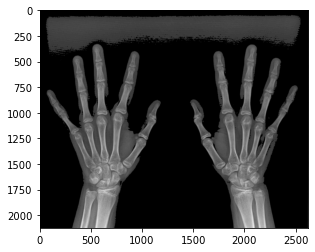

In [46]:
gray = cv2.bitwise_and(gray,gray, mask=msk)
plt.imshow(gray,'gray')

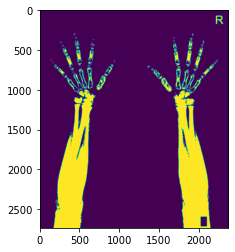

In [622]:
plt.imshow(gray>20)

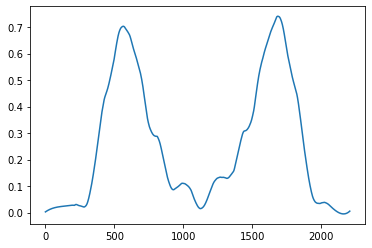

In [194]:
smoothed = savgol_filter(h,311,3)
plt.plot(smoothed)